# Collaborative filtering
(probabilistic matrix factorization)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *
from fastai.column_data import *

## Dataset - Movielens

In [3]:
PATH = 'data/ml-latest-small/'

In [4]:
ratings = pd.read_csv(PATH + 'ratings.csv')

In [5]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [6]:
movies = pd.read_csv(PATH + 'movies.csv')

In [7]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


### Get an overview over data: cross table of most popular movies and most activer users

In [8]:
# Top users
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]

# Top movies
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [9]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


## Collaborative filtering
Describe every user and every movie as a vector (latent factor) which gives us two embedding matrices. The dot product of a user and a movie factor/vector gives the rating. When two users have a *similiar* filter, they have a similiar taste in movies.

In [10]:
val_idxs = get_cv_idxs(len(ratings))
wd = 2e-4  # weight decay
n_factors = 50

In [11]:
data = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 'userId', 'movieId', 'rating')

In [12]:
learn = data.get_learner(n_factors=n_factors, val_idxs=val_idxs, bs=64, opt_fn=optim.Adam)

In [13]:
learn.fit(1e-2, n_cycle=2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.745285   0.773615  
    1      0.718607   0.75155                                   
    2      0.587384   0.738033                                  



[array([0.73803])]

**This gives a better loss in 20 seconds than those [benchmarks](https://www.librec.net/release/v1.3/example.html):**

loss = 0.91 (RMSE)

In [14]:
math.sqrt(0.738)

0.8590692637965812

In [15]:
y = learn.data.val_y
preds = learn.predict()

/home/fabiograetz/anaconda3/envs/deeplearning_save_2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


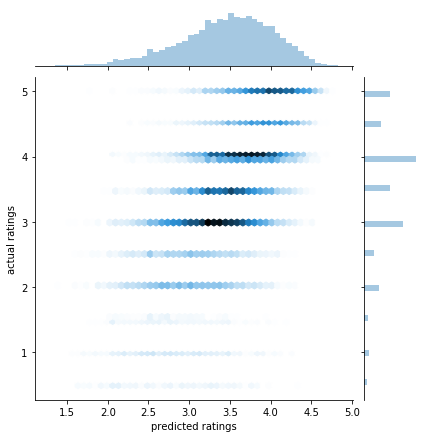

In [16]:
g = (sns.jointplot(preds, y, kind='hex', stat_func=None,).set_axis_labels('predicted ratings', 'actual ratings'))

## Analyze results

In [ ]:
142

## Collaborative filter from scratch in pytorch

Dot product

In [19]:
class DotProduct(nn.Module):
    def forward(self, u, m):
        return (u*m).sum(1)

In [20]:
a = T([[1, 2],[3, 4]])
b = T([[2, 2],[10, 10]])

In [21]:
model = DotProduct()

In [22]:
model(a, b)


  6
 70
[torch.cuda.LongTensor of size 2 (GPU 0)]

## Dot product model
The userIds and movieIds might not be contiguos. Create a dictionary and replace them with congiguos indices!

In [29]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}

In [31]:
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

In [32]:
m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}

In [35]:
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [36]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())

In [38]:
n_users, n_movies

(610, 9724)

In [55]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=50):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)
        
    def forward(self, ids, conts):
        users, movies = ids[:,0], ids[:,1]
        u, m = self.u(users), self.m(movies)
        return (u*m).sum(1)

In [56]:
x = ratings.drop(['rating', 'timestamp'], axis=1)

In [57]:
y = ratings['rating'].astype(np.float32)

In [58]:
x.columns

Index(['userId', 'movieId'], dtype='object')

In [59]:
data = ColumnarModelData.from_data_frame(PATH, val_idxs, x, y, ['userId', 'movieId'], bs=64)

In [60]:
wd = 1e-5
model = EmbeddingDot(n_users, n_movies).cuda()

In [61]:
opt = optim.SGD(model.parameters(), lr=1e-1, weight_decay=wd, momentum=0.9)

**Cool thing: we are not using a learner object here, we simply call fit() on a pytorch module. So whenever you want to run pytorch code but don't want to write the training loop, use the fit function of fastai. No SGDR though :(**

In [62]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                 
    0      1.65061    1.599325  
    1      1.051055   1.294526                                 
    2      0.908719   1.236511                                  



[array([1.23651])]

In [64]:
set_lrs(opt, 0.01)

In [65]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.701933   1.156304  
    1      0.66726    1.14357                                   
    2      0.667784   1.136906                                  



[array([1.13691])]

Not as good as standard fastai collaborative filtering, so, let's improve it.

## Add Bias

**Problem: We did not account for the fact that some users, on average, give higher reviews and some movies, on average, are more hyped. Bias fixes this. The user bias states how *enthusiastic* a user is, for instance.**

In [68]:
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [81]:
class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, m_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [self.get_emb(*o) for o in [
            (n_users, n_factors),(n_movies, n_factors),(n_users,1),(n_movies,1)]]
    
    def get_emb(self, ni, nf):
        e = nn.Embedding(ni, nf)
        e.weight.data.uniform_(-0.01,0.01)
        return e
    
    def forward(self, ids, conts):
        users, movies = ids[:,0], ids[:,1]
        um = (self.u(users)*self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() 
        res = F.sigmoid(res) * (max_rating - min_rating) + min_rating
        return res

In [82]:
wd = 2e-4
model = EmbeddingDotBias(n_users, n_movies).cuda()

In [83]:
opt = optim.SGD(model.parameters(), lr=1e-1, weight_decay=wd, momentum=0.9)

In [84]:
fit(model, data, n_epochs=3, opt=opt, crit=F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.822945   0.816392  
    1      0.761763   0.794602                                  
    2      0.714267   0.789599                                  



[array([0.7896])]

In [85]:
set_lrs(opt, 1e-2)

In [86]:
fit(model, data, n_epochs=3, opt=opt, crit=F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.687754   0.781357  
    1      0.7125     0.780176                                  
    2      0.70677    0.779601                                  



[array([0.7796])]

## Mini neural net

In [88]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [(n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        self.max_score = 5
        self.min_score = 1
        
    def forward(self, ids, conts):
        users, movies = ids[:,0], ids[:,1]
        x = self.drop1(torch.cat([self.u(users), self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (self.max_score - self.min_score) + self.min_score
        
    def get_emb(self, ni, nf):
        e = nn.Embedding(ni, nf)
        e.weight.data.uniform_(-0.01,0.01)
        return e

**The course uses *mean squared error* despite the fact that the activation function in the last layer is *sigmoid*. I assume it does this for the sake of comparability to prev. experiments in this notebook. You should use *cross-entropy* with *sigmoid*.**

In [89]:
wd = 1e-5
model = EmbeddingNet(n_users, n_movies).cuda()

In [90]:
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=wd)

In [91]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.837294   0.781068  
    1      0.751687   0.763913                                  
    2      0.751389   0.766896                                  



[array([0.7669])]

In [92]:
set_lrs(opt, 1e-3)

In [93]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.750949   0.773396  
    1      0.720005   0.776879                                  
    2      0.686353   0.77446                                   



[array([0.77446])]

**If you want to improve on this, make another embedding for the genre, release year, etc. and concatonate everything together before feeding it into the neural net.**